## Ví dụ 1.

## Generate a linearly separable 2D dataset

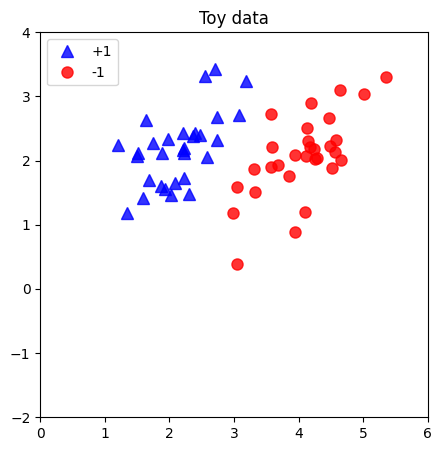

In [25]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

means = [[2, 2], [4, 2]]
cov   = [[.3, .2], [.2, .3]]
N     = 30

# Each class as 2 x N (rows = features, cols = samples)
X0 = np.random.multivariate_normal(means[0], cov, N).T
X1 = np.random.multivariate_normal(means[1], cov, N).T

# Stack: X is 2 x (2N)
X_2d = np.concatenate([X0, X1], axis=1)

# Labels y in {+1, -1}, shape (2N,)
y = np.concatenate([np.ones(N), -np.ones(N)])

# Add bias row x0 = 1  → X becomes 3 x (2N)
X = np.vstack([np.ones(X_2d.shape[1]), X_2d])  # (3, 2N)

# Quick look
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X0[0, :], X0[1, :], "b^", ms=8, alpha=.8, label="+1")
ax.plot(X1[0, :], X1[1, :], "ro", ms=8, alpha=.8, label="-1")
ax.set_xlim(0, 6); ax.set_ylim(-2, 4); ax.legend()
ax.set_title("Toy data")
plt.show()


## Perceptron core

In [26]:
def sign_stable(a):
    return np.where(a >= 0, 1.0, -1.0)

def h(w, X):
    w = w.reshape(-1, 1)       # (3,1)
    scores = (w.T @ X).ravel() # (M,)
    return sign_stable(scores)

def has_converged(X, y, w):
    """True if all points are correctly classified."""
    return np.array_equal(h(w, X), y)

def perceptron(X, y, w_init, max_iter=10_000, shuffle=True):
    w = [w_init.reshape(-1, 1).astype(float)]
    M = X.shape[1]
    mis_points = []

    it = 0
    while it < max_iter:
        if shuffle:
            idx = np.random.permutation(M)
        else:
            idx = np.arange(M)

        any_update = False
        for i in idx:
            xi = X[:, [i]]             # (3,1)
            yi = y[i]                  # scalar in {+1,-1}
            if sign_stable(float(w[-1].T @ xi)) != yi:
                w_new = w[-1] + yi * xi
                w.append(w_new)
                mis_points.append(i)
                any_update = True

        if not any_update or has_converged(X, y, w[-1]):
            break
        it += 1

    return w, mis_points

# Run
w_init = np.random.randn(3, 1)
w_hist, mis_idx = perceptron(X, y, w_init)
print("Final w:\n", w_hist[-1].ravel())
print("Updates:", len(w_hist)-1)


Final w:
 [ 13.97858527 -15.02901929  14.38743059]
Updates: 75


C:\Users\Hoang\AppData\Local\Temp\ipykernel_14056\96204841.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if sign_stable(float(w[-1].T @ xi)) != yi:


## Helper to draw the decision boundary

In [27]:
def draw_line(ax, w, xlim=(0,6), ylim=(-2,4), **kwargs):
    """
    Draw decision boundary w0 + w1*x + w2*y = 0 on axes ax.
    """
    w0, w1, w2 = w.ravel()
    if abs(w2) > 1e-12:  # non-vertical
        x1, x2 = xlim
        y1 = -(w1*x1 + w0)/w2
        y2 = -(w1*x2 + w0)/w2
        ax.plot([x1, x2], [y1, y2], **kwargs)
    else:  # vertical line: w1*x + w0 = 0
        x0 = -w0 / (w1 + 1e-12)
        ax.plot([x0, x0], list(ylim), **kwargs)


## Static plot of the final separator

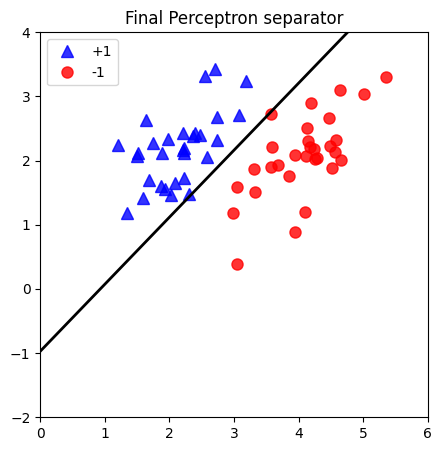

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X0[0, :], X0[1, :], "b^", ms=8, alpha=.8, label="+1")
ax.plot(X1[0, :], X1[1, :], "ro", ms=8, alpha=.8, label="-1")
draw_line(ax, w_hist[-1], color="k", linewidth=2)
ax.set_xlim(0, 6); ax.set_ylim(-2, 4); ax.legend()
ax.set_title("Final Perceptron separator")
plt.show()


## Ví dụ 2.

### Import libaries

In [29]:
import os, time
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


### Import dataset

In [30]:
df = pd.read_csv(r'D:\hocmay\week10(week8)\sonar.all-data.csv', header=None)
assert df.shape[1] == 61, f"Expected 61 columns, got {df.shape[1]}"
print(df.head())

       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      51      52      53      54      55      56      57  \
0  0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1  0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2  0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3  0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4  0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   

       58      59  60  
0  0.0090  0.0032   R  
1  0.0052  0.0044   R  
2  0.0095  0.0078   

### Map labels {'M','R'} -> {1,-1} and build X with x0=1

In [31]:
y_raw = df[60].astype(str)
label_map = {"M": 1, "R": -1}
y = y_raw.map(label_map).to_numpy()

X0 = np.ones((df.shape[0], 1), dtype=float)
X  = np.hstack([X0, df.drop(columns=[60]).to_numpy(dtype=float)])

# Train/test split 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Class balance (train):", {c:int((y_train==c).sum()) for c in np.unique(y_train)})
print("Class balance (test) :", {c:int((y_test==c).sum()) for c in np.unique(y_test)})

X_train: (145, 61) | X_test: (63, 61)
Class balance (train): {np.int64(-1): 68, np.int64(1): 77}
Class balance (test) : {np.int64(-1): 29, np.int64(1): 34}


### (a) FROM-SCRATCH LOGISTIC REGRESSION (NumPy, binary)

In [32]:
def sigmoid(z):
    # Clip for numerical stability
    z = np.clip(z, -40, 40)
    return 1.0 / (1.0 + np.exp(-z))


In [33]:
def binlogistic_train_numpy(X, y, lr=0.05, epochs=2000, l2=0.0, standardize=True):
    Xw = X.copy()
    scaler_mean, scaler_std = None, None

    # Optionally standardize features *except* bias column
    if standardize:
        scaler_mean = Xw[:,1:].mean(axis=0, keepdims=True)
        scaler_std  = Xw[:,1:].std(axis=0, ddof=0, keepdims=True) + 1e-9
        Xw[:,1:] = (Xw[:,1:] - scaler_mean) / scaler_std

    n, d = Xw.shape
    w = np.zeros(d)

    # y in {+1,-1}; logistic loss uses margin y * (Xw @ w)
    for _ in range(epochs):
        margins = y * (Xw @ w)
        probs   = sigmoid(margins)          
        # gradient of logistic loss wrt w:
        # dL/dw = - (1/n) * sum( y * (1 - sigmoid(y w^T x)) * x ) + l2 * w
        grad = -(Xw * (y * (1.0 - probs))[:,None]).mean(axis=0) + l2 * w
        w -= lr * grad

    return w, scaler_mean, scaler_std

In [34]:
def binlogistic_predict_numpy(X, w, scaler_mean=None, scaler_std=None):
    Xw = X.copy()
    if scaler_mean is not None and scaler_std is not None:
        Xw[:,1:] = (Xw[:,1:] - scaler_mean) / scaler_std
    scores = Xw @ w
    yhat = np.where(scores >= 0.0, 1, -1)
    return yhat

# Train from scratch
t0 = time.perf_counter()
w, mu, sd = binlogistic_train_numpy(X_train, y_train, lr=0.05, epochs=3000, l2=1e-4, standardize=True)
t1 = time.perf_counter()

# Predict
y_pred_fs = binlogistic_predict_numpy(X_test, w, mu, sd)

### (b) METRICS: accuracy / precision / recall + confusion matrix

In [35]:
acc_fs = accuracy_score(y_test, y_pred_fs)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_test, y_pred_fs, average="macro", zero_division=0
)
cm_fs = confusion_matrix(y_test, y_pred_fs, labels=[1,-1])

print("\n=== (a)+(b) From-Scratch Logistic (NumPy) ===")
print(f"Train time: {(t1 - t0):.4f} s")
print(f"Accuracy : {acc_fs:.4f}")
print(f"Precision (macro) / Recall (macro) / F1 (macro): {prec_m:.4f} / {rec_m:.4f} / {f1_m:.4f}")
print("Confusion matrix (labels=[1,-1]):\n", cm_fs)
print("\nClassification report:")
print(classification_report(y_test, y_pred_fs, target_names=["Mine(+1)","Rock(-1)"], zero_division=0))



=== (a)+(b) From-Scratch Logistic (NumPy) ===
Train time: 0.0612 s
Accuracy : 0.7619
Precision (macro) / Recall (macro) / F1 (macro): 0.7667 / 0.7667 / 0.7619
Confusion matrix (labels=[1,-1]):
 [[24 10]
 [ 5 24]]

Classification report:
              precision    recall  f1-score   support

    Mine(+1)       0.71      0.83      0.76        29
    Rock(-1)       0.83      0.71      0.76        34

    accuracy                           0.76        63
   macro avg       0.77      0.77      0.76        63
weighted avg       0.77      0.76      0.76        63



### (c) SKLEARN COMPARISON: Logistic vs Gaussian Naïve Bayes with timing and the same split

In [36]:
def run_model(name, pipe, Xtr, ytr, Xte, yte):
    t0 = time.perf_counter()
    pipe.fit(Xtr, ytr)
    t1 = time.perf_counter()
    ypred = pipe.predict(Xte)
    acc = accuracy_score(yte, ypred)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        yte, ypred, average="macro", zero_division=0
    )
    print(f"\n=== {name} ===")
    print(f"Train time: {(t1 - t0):.4f} s")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision (macro) / Recall (macro) / F1 (macro): {prec_m:.4f} / {rec_m:.4f} / {f1_m:.4f}")
    print("Confusion matrix (labels=[1,-1]):\n", confusion_matrix(yte, ypred, labels=[1,-1]))
    return acc

In [37]:
# LogisticRegression (with scaling; bias already present but scaling ignores x0)
pipe_logreg = Pipeline([
    ("scale", StandardScaler(with_mean=True)),
    ("clf",   LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# Gaussian Naïve Bayes (NB typically doesn't need scaling, but small benefit is harmless)
pipe_gnb = Pipeline([
    ("scale", StandardScaler(with_mean=True)),
    ("gnb",   GaussianNB())
])

In [38]:
acc_lr  = run_model("LogisticRegression (sklearn)", pipe_logreg, X_train, y_train, X_test, y_test)
acc_gnb = run_model("Gaussian Naïve Bayes",       pipe_gnb,   X_train, y_train, X_test, y_test)

print("\n--- Summary (accuracy) ---")
print(f"From-scratch Logistic (NumPy): {acc_fs:.4f}")
print(f"sklearn LogisticRegression   : {acc_lr:.4f}")
print(f"Gaussian Naïve Bayes         : {acc_gnb:.4f}")


=== LogisticRegression (sklearn) ===
Train time: 0.0064 s
Accuracy : 0.7619
Precision (macro) / Recall (macro) / F1 (macro): 0.7667 / 0.7667 / 0.7619
Confusion matrix (labels=[1,-1]):
 [[24 10]
 [ 5 24]]

=== Gaussian Naïve Bayes ===
Train time: 0.0009 s
Accuracy : 0.7619
Precision (macro) / Recall (macro) / F1 (macro): 0.7626 / 0.7642 / 0.7617
Confusion matrix (labels=[1,-1]):
 [[25  9]
 [ 6 23]]

--- Summary (accuracy) ---
From-scratch Logistic (NumPy): 0.7619
sklearn LogisticRegression   : 0.7619
Gaussian Naïve Bayes         : 0.7619


## Ví dụ 3.

### Imports library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

RANDOM_STATE = 109  

### Load Dataset & Train/Test Split

In [ ]:
cancer = datasets.load_breast_cancer()
X = cancer.data              
y = cancer.target            
target_names = cancer.target_names  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Class balance (train):", np.bincount(y_train))
print("Class balance (test): ", np.bincount(y_test))


### Dimensionality Reduction to 2D

In [ ]:
pca2_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=RANDOM_STATE))
])

X_train_2d = pca2_pipe.fit_transform(X_train)
X_test_2d  = pca2_pipe.transform(X_test)

print("2D shapes:", X_train_2d.shape, X_test_2d.shape)


### 2D Visualization

In [ ]:
def plot_2d(X2d, y, title="Breast Cancer (PCA 2D)"):
    plt.figure(figsize=(6,5))
    for lab, marker, color in zip([0,1], ["o","^"], ["tomato","steelblue"]):
        idx = (y == lab)
        plt.scatter(X2d[idx, 0], X2d[idx, 1], s=25, marker=marker, c=color, label=target_names[lab], alpha=0.8)
    plt.axhline(0, ls="--", lw=0.8, c="grey")
    plt.axvline(0, ls="--", lw=0.8, c="grey")
    plt.legend()
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_2d(X_train_2d, y_train, title="Train set (PCA 2D)")
plot_2d(X_test_2d,  y_test,  title="Test set (PCA 2D)")


### Evaluation Helpers & Metrics

In [ ]:
def evaluate_and_report(name, clf, Xtr, ytr, Xte, yte, cm_title=None):
    clf.fit(Xtr, ytr)
    y_pred = clf.predict(Xte)

    acc = accuracy_score(yte, y_pred)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        yte, y_pred, average="macro", zero_division=0
    )
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        yte, y_pred, average="weighted", zero_division=0
    )

    print(f"\n=== {name} ===")
    print(f"Accuracy         : {acc:.4f}")
    print(f"Precision (macro): {prec_m:.4f} | Recall (macro): {rec_m:.4f} | F1 (macro): {f1_m:.4f}")
    print(f"Precision (wtd)  : {prec_w:.4f} | Recall (wtd) : {rec_w:.4f} | F1 (wtd) : {f1_w:.4f}")

    cm = confusion_matrix(yte, y_pred, labels=[0,1])  
    disp = ConfusionMatrixDisplay(cm, display_labels=[target_names[0], target_names[1]])
    disp.plot(values_format="d", cmap="Blues")
    plt.title(cm_title or f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

    return acc


### Training & Comparison on Original 30D Features

In [ ]:
pipe_lr_orig = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, n_jobs=None, random_state=RANDOM_STATE))
])

pipe_pct_orig = Pipeline([
    ("scale", StandardScaler()),
    ("clf", Perceptron(max_iter=2000, tol=1e-3, random_state=RANDOM_STATE))
])

acc_lr_orig  = evaluate_and_report(
    "Logistic Regression (original 30D)",
    pipe_lr_orig, X_train, y_train, X_test, y_test
)

acc_pct_orig = evaluate_and_report(
    "Perceptron (original 30D)",
    pipe_pct_orig, X_train, y_train, X_test, y_test
)


### Training & Comparison on PCA-Reduced 2D Features

In [ ]:
clf_lr_2d = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)
acc_lr_2d = evaluate_and_report(
    "Logistic Regression (PCA 2D)",
    clf_lr_2d, X_train_2d, y_train, X_test_2d, y_test
)


clf_pct_2d = Perceptron(max_iter=2000, tol=1e-3, random_state=RANDOM_STATE)
acc_pct_2d = evaluate_and_report(
    "Perceptron (PCA 2D)",
    clf_pct_2d, X_train_2d, y_train, X_test_2d, y_test
)
